### Data

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from io import StringIO

In [60]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# -------------------------------
# 1. Cargar datos
# -------------------------------
df = pd.read_csv("diamonds.csv")
df = df.drop(columns=["id"])

# -------------------------------
# 2. Log-transform de price
# -------------------------------
y = np.log(df["price"])   # <-- aquí el log
X = df.drop(columns=["price"])

# -------------------------------
# 3. Split train/test
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# -------------------------------
# 4. Columnas categóricas y numéricas
# -------------------------------
categorical_cols = ["cut", "color", "clarity"]
numeric_cols = ["carat", "depth", "table", "x", "y", "z"]

# -------------------------------
# 5. One-hot encoding
# -------------------------------
encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")

X_train_cat = encoder.fit_transform(X_train[categorical_cols])
X_test_cat  = encoder.transform(X_test[categorical_cols])

# -------------------------------
# 6. Escalado de variables numéricas
# -------------------------------
scaler = StandardScaler()

X_train_num = scaler.fit_transform(X_train[numeric_cols])
X_test_num  = scaler.transform(X_test[numeric_cols])

# -------------------------------
# 7. Combinar numéricas + categóricas
# -------------------------------
X_train_final = np.hstack([X_train_num, X_train_cat])
X_test_final  = np.hstack([X_test_num,  X_test_cat])

# -------------------------------
# 8. Escalado de la variable objetivo (opcional, pero útil para NN)
# -------------------------------
y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled  = y_scaler.transform(y_test.values.reshape(-1, 1))  # <-- solo transform

# -------------------------------
# 9. Convertir a numpy arrays
# -------------------------------
y_train_scaled = np.array(y_train_scaled)
y_test_scaled  = np.array(y_test_scaled)

print("Shape X_train:", X_train_final.shape)
print("Shape X_test :", X_test_final.shape)
print("Shape y_train:", y_train_scaled.shape)
print("Shape y_test :", y_test_scaled.shape)


Shape X_train: (43152, 26)
Shape X_test : (10788, 26)
Shape y_train: (43152, 1)
Shape y_test : (10788, 1)


### PyTorch

In [61]:
import torch
import torch.optim as optim
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets,transforms

In [62]:
class NeuralNetwork(nn.Module):
    def __init__(self, n_features, dropout_rate=0.5):
        super().__init__()
        # Definimos la capa Dropout
        self.dropout = nn.Dropout(p=dropout_rate) # Usando 0.5 como valor estándar
        
        self.flatten = nn.Flatten()
        
        # Insertamos la capa Dropout en el stack
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(n_features, 64),
            nn.Tanh(),
            # 1. Añadimos Dropout después de la primera ReLU
            self.dropout, 
            nn.Linear(64, 32),
            nn.Tanh(),
            self.dropout, 
            nn.Linear(32, 1)
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.linear_relu_stack(x)
        return x

In [63]:
model = NeuralNetwork(n_features=X_train_final.shape[1])
print(model)

NeuralNetwork(
  (dropout): Dropout(p=0.5, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=26, out_features=64, bias=True)
    (1): Tanh()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): Tanh()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [64]:
# 4. Convertir a tensores
X_train_tensor = torch.tensor(X_train_final, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32).view(-1, 1)

X_test_tensor = torch.tensor(X_test_final, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32).view(-1, 1)

In [65]:
epochs = 400

train_losses = []
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Entrenamiento
for epoch in range(epochs):
    # Forward
    y_pred = model(X_train_tensor)
    loss = criterion(y_pred, y_train_tensor)

    optimizer.zero_grad()  # reiniciar gradientes
    loss.backward()        # calcular gradientes
    optimizer.step()        # actualizar pesos

    train_losses.append(loss.item())
    

    # Mostrar progreso
    if (epoch + 1) % 20 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.6f}")


Epoch [20/400], Loss: 0.244202
Epoch [40/400], Loss: 0.146313
Epoch [60/400], Loss: 0.118019
Epoch [80/400], Loss: 0.104028
Epoch [100/400], Loss: 0.096409
Epoch [120/400], Loss: 0.089624
Epoch [140/400], Loss: 0.086034
Epoch [160/400], Loss: 0.082541
Epoch [180/400], Loss: 0.078871
Epoch [200/400], Loss: 0.075948
Epoch [220/400], Loss: 0.073790
Epoch [240/400], Loss: 0.072804
Epoch [260/400], Loss: 0.071538
Epoch [280/400], Loss: 0.069982
Epoch [300/400], Loss: 0.069782
Epoch [320/400], Loss: 0.069272
Epoch [340/400], Loss: 0.068380
Epoch [360/400], Loss: 0.068211
Epoch [380/400], Loss: 0.066999
Epoch [400/400], Loss: 0.066381


In [66]:
# Predicciones del modelo
model.eval()  # modo evaluación (sin dropout, etc)
with torch.no_grad():
    y_pred_train = model(X_train_tensor).numpy()

# Convertir a numpy si hace falta
y_true = y_train_tensor.numpy()

# Calcular R²
from sklearn.metrics import r2_score, mean_squared_error

r2 = r2_score(y_true, y_pred_train)
mse = mean_squared_error(y_true, y_pred_train)
print(f"R²: {r2:.4f}")
print(f"MSE: {mse:.4f}")


R²: 0.9772
MSE: 0.0228


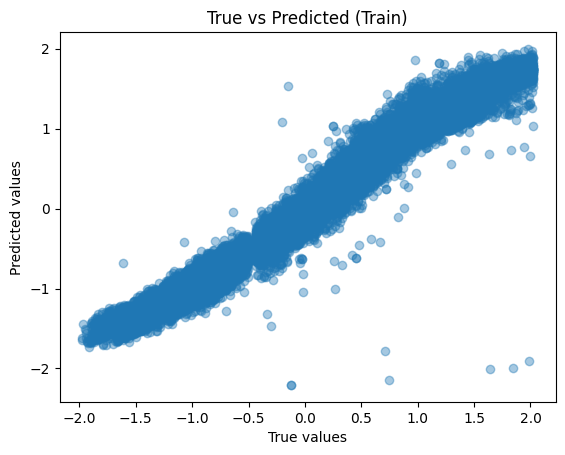

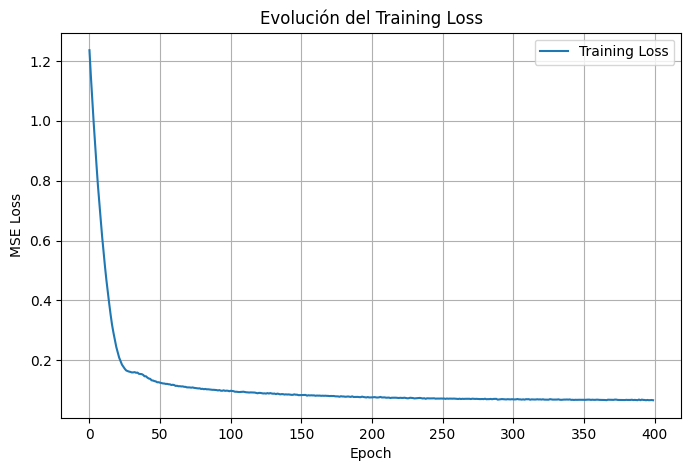

In [67]:
plt.scatter(y_true, y_pred_train, alpha=0.4)
plt.xlabel("True values")
plt.ylabel("Predicted values")
plt.title("True vs Predicted (Train)")
plt.show()

plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Evolución del Training Loss")
plt.legend()
plt.grid(True)
plt.show()


In [68]:
model.eval()  # Modo evaluación: desactiva dropout, batchnorm, etc.

with torch.no_grad():
    y_pred_test = model(X_test_tensor)
    test_loss = criterion(y_pred_test, y_test_tensor)

print(f"Test Loss (MSE): {test_loss.item():.6f}")

Test Loss (MSE): 0.021601


In [69]:
from sklearn.metrics import r2_score

# Convertimos a numpy
y_test_np = y_test_tensor.numpy()
y_pred_np = y_pred_test.numpy()

r2 = r2_score(y_test_np, y_pred_np)
print(f"R² en test: {r2:.4f}")

R² en test: 0.9785


### OWN NN

In [130]:
import numpy as np
from sklearn.model_selection import train_test_split


class NeuralNet:
    def __init__(self, layers, epochs=500, lr=0.001, momentum=0.3, 
                 function='tanh', perc_validation=0.2):
        """
        Inicializa la red neuronal.
        
        Args:
            layers: Lista con el número de neuronas por capa
            epochs: Número de iteraciones de entrenamiento
            lr: Learning rate (tasa de aprendizaje)
            momentum: Coeficiente de momentum
            function: Función de activación ('tanh' o 'sigmoid')
            perc_validation: Porcentaje de datos para validación
        """
        self.layers = layers
        self.epochs = epochs
        self.lr = lr
        self.momentum = momentum
        self.function = function
        self.perc_validation = perc_validation
        
        self.X_train = None
        self.X_val = None
        self.X_test = None
        self.y_train = None
        self.y_val = None
        self.y_test = None
        
        self.weights = []
        self.biases = []
        self.train_errors = []
        self.val_errors = []
        self.velocity_w = []
        self.velocity_b = []
        
        self.scaler_y = None  # Escalador de y para desnormalizar
        
        self._init_weights()
    
    def _init_weights(self):
        """Inicializa pesos y biases aleatoriamente (Xavier initialization)."""
        np.random.seed(42)
        self.weights = []
        self.biases = []
        self.velocity_w = []
        self.velocity_b = []
        
        for i in range(len(self.layers) - 1):
            limit = np.sqrt(6 / (self.layers[i] + self.layers[i+1]))
            w = np.random.uniform(-limit, limit, (self.layers[i], self.layers[i+1]))
            b = np.zeros((1, self.layers[i+1]))
            
            self.weights.append(w)
            self.biases.append(b)
            self.velocity_w.append(np.zeros_like(w))
            self.velocity_b.append(np.zeros_like(b))
    
    def _activation(self, x):
        """Aplica la función de activación."""
        if self.function == 'tanh':
            return np.tanh(x)
        elif self.function == 'sigmoid':
            return 1 / (1 + np.exp(-np.clip(x, -500, 500)))
        elif self.function == 'relu':
            return np.maximum(0, x)
    
    def _activation_derivative(self, x):
        """Derivada de la función de activación."""
        if self.function == 'tanh':
            return 1 - np.tanh(x) ** 2
        elif self.function == 'sigmoid':
            sig = 1 / (1 + np.exp(-np.clip(x, -500, 500)))
            return sig * (1 - sig)
        elif self.function == 'relu':
            return np.where(x > 0, 1, 0)
    
    def _forward(self, X):
        """Forward propagation. Retorna activaciones e inputs pre-activación."""
        activations = [X]
        z_values = []
        
        for i in range(len(self.weights)):
            z = np.dot(activations[-1], self.weights[i]) + self.biases[i]
            z_values.append(z)
            
            if i < len(self.weights) - 1:  # No activación en la última capa
                a = self._activation(z)
            else:
                a = z  # Salida lineal
            
            activations.append(a)
        
        return activations, z_values
    
    def _backward(self, activations, z_values, y):
        """Backpropagation. Calcula gradientes."""
        m = y.shape[0]
        deltas = []
        
        # Error en la capa de salida
        error = activations[-1] - y
        deltas.append(error)
        
        # Backpropagate error
        for i in range(len(self.weights) - 2, -1, -1):
            delta = np.dot(deltas[0], self.weights[i+1].T) * self._activation_derivative(z_values[i])
            deltas.insert(0, delta)
        
        # Actualizar pesos y biases con momentum
        for i in range(len(self.weights)):
            dw = np.dot(activations[i].T, deltas[i]) / m
            db = np.sum(deltas[i], axis=0, keepdims=True) / m
            
            # Aplicar momentum
            self.velocity_w[i] = self.momentum * self.velocity_w[i] - self.lr * dw
            self.velocity_b[i] = self.momentum * self.velocity_b[i] - self.lr * db
            
            self.weights[i] += self.velocity_w[i]
            self.biases[i] += self.velocity_b[i]
    
    def _mse(self, y_true, y_pred):
        """Calcula el error cuadrático medio."""
        return np.mean((y_true - y_pred) ** 2)
    
    def fit(self, X, y, scaler_y=None):
        """
        Entrena la red neuronal.
        
        Args:
            X: Características de entrada (ya normalizadas)
            y: Etiquetas/valores objetivo (ya normalizados)
            scaler_y: Escalador de y para desnormalizar predicciones (opcional)
        """
        self.scaler_y = scaler_y
        # Split 80/20 entrenamiento/test
        X_train, self.X_test, y_train, self.y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )
        
        # Split del entrenamiento para validación
        if self.perc_validation > 0:
            split_idx = int(len(X_train) * (1 - self.perc_validation))
            self.X_train = X_train[:split_idx]
            self.X_val = X_train[split_idx:]
            self.y_train = y_train[:split_idx]
            self.y_val = y_train[split_idx:]
        else:
            self.X_train = X_train
            self.X_val = np.array([])
            self.y_train = y_train
            self.y_val = np.array([])
        
        # Asegurar que y tiene forma (n_samples, 1)
        if self.y_train.ndim == 1:
            self.y_train = self.y_train.reshape(-1, 1)
        if self.y_val.size > 0 and self.y_val.ndim == 1:
            self.y_val = self.y_val.reshape(-1, 1)
        if self.y_test.ndim == 1:
            self.y_test = self.y_test.reshape(-1, 1)
        
        # Entrenar
        self.train_errors = []
        self.val_errors = []
        
        for epoch in range(self.epochs):
            # Forward y backward en entrenamiento
            activations, z_values = self._forward(self.X_train)
            self._backward(activations, z_values, self.y_train)
            
            # Calcular error de entrenamiento
            train_pred, _ = self._forward(self.X_train)
            train_loss = self._mse(self.y_train, train_pred[-1])
            self.train_errors.append(train_loss)
            
            # Calcular error de validación
            if self.X_val.shape[0] > 0:
                val_pred, _ = self._forward(self.X_val)
                val_loss = self._mse(self.y_val, val_pred[-1])
                self.val_errors.append(val_loss)
            else:
                self.val_errors.append(None)
            
            if (epoch + 1) % 100 == 0:
                val_str = f", Val: {self.val_errors[-1]:.6f}" if self.val_errors[-1] is not None else ""
                print(f"Epoch {epoch + 1}/{self.epochs}, Train MSE: {train_loss:.6f}{val_str}")
    
    def predict(self, X):
        """
        Realiza predicciones.
        
        Args:
            X: Características de entrada (ya normalizadas)
            
        Returns:
            Predicciones
        """
        activations, _ = self._forward(X)
        return activations[-1]
    
    def predict_original_scale(self, X):
        """
        Realiza predicciones y las desnormaliza a escala original.
        
        Args:
            X: Características de entrada (ya normalizadas)
            
        Returns:
            Predicciones en escala original
        """
        predictions = self.predict(X)
        if self.scaler_y is not None:
            predictions = self.scaler_y.inverse_transform(predictions)
        return predictions
    
    def loss_epochs(self):
        """
        Retorna los errores de entrenamiento y validación por epoch.
        
        Returns:
            Tupla (train_errors, val_errors)
        """
        return self.train_errors, self.val_errors

In [158]:
import numpy as np
import warnings
from sklearn.preprocessing import StandardScaler

class NeuralNet:
    def __init__(self, layers, epochs, lr, momentum, function, perc_validation):
        self.L = len(layers)    # Number of layers
        self.n = layers.copy()  # An array with the number of units in each layer

        self.h = []             # An array of arrays for the fields (h)
        for lay in range(self.L):
            self.h.append(np.zeros(layers[lay]))
        self.xi = []            # An array of arrays for the activations(Xi)
        for lay in range(self.L):
            self.xi.append(np.zeros(layers[lay]))

        self.w = []             # An array of matrices for the weights
        self.w.append(np.zeros((1, 1)))
        for lay in range(1, self.L):
            self.w.append(np.zeros((layers[lay], layers[lay - 1])))

        self.theta = []         # An array of arrays for thresholds
        for lay in range(self.L):
            self.theta.append(np.zeros(layers[lay]))
        
        self.delta = []         # An array of arrays for the propagation errors
        for lay in range(self.L):
            self.delta.append(np.zeros(layers[lay]))
            
        self.d_w = []           # An array of matrices for the changes on weights
        self.d_w.append(np.zeros((1, 1)))
        for lay in range(1, self.L):
            self.d_w.append(np.zeros((layers[lay], layers[lay - 1])))
        
        self.d_theta = []       # An array of arrays for the changes on thresholds
        for lay in range(self.L):
            self.d_theta.append(np.zeros(layers[lay]))
            
        self.d_w_prev = []      # Momentum term weights
        self.d_w_prev.append(np.zeros((1, 1)))
        for lay in range(1, self.L):
            self.d_w_prev.append(np.zeros((layers[lay], layers[lay - 1])))
            
        self.d_theta_prev = []  # Momentum term thresholds
        for lay in range(self.L):
            self.d_theta_prev.append(np.zeros(layers[lay]))                     
        
        self.fact = function      
        self.epochs = epochs
        self.lr = lr
        self.momentum = momentum
        self.perc_validation = perc_validation
        
        self.train_errors = []
        self.val_errors = []
                                
    def _activation(self, x):
        if self.fact == 'sigmoid':
            return 1 / (1 + np.exp(-x))
        elif self.fact == 'tanh':
            return np.tanh(x)
        elif self.fact == 'relu':
            return np.maximum(0, x)
        elif self.fact == 'linear':
            return x
        else:
            raise ValueError(f"Function {self.fact} not supported")

    def _activation_derivative(self, x):
        if self.fact == 'sigmoid':
            s = self._activation(x)
            return s * (1 - s)
        elif self.fact == 'tanh':
            s = self._activation(x)
            return 1 - s**2
        elif self.fact == 'relu':
            return (x > 0).astype(float)
        elif self.fact == 'linear':
            return np.ones_like(x)
        else:
            raise ValueError(f"Función {self.fact} no soportada")

    def initialize_w_theta(self):
        np.random.seed(42) # Para reproducibilidad
        for L in range(1, self.L):
            # Inicialización de Xavier / Glorot
            limit = np.sqrt(6 / (self.n[L] + self.n[L - 1]))
            self.w[L] = np.random.uniform(-limit, limit, size=(self.n[L], self.n[L - 1]))
            self.theta[L] = np.zeros(self.n[L]) 
            
    def feed_forward(self, X):
        self.xi[0] = X
        for L in range(1, self.L):
            # h[L] = w[L] * xi[L-1] - theta[L]
            self.h[L] = self.w[L].dot(self.xi[L-1]) - self.theta[L]

            # --- MODIFICACIÓN CRÍTICA: SALIDA LINEAL ---
            if L == self.L - 1:
                # Si es la última capa, pasamos el valor tal cual (Identidad)
                # Esto permite predecir valores fuera del rango [-1, 1]
                self.xi[L] = self.h[L]
            else:
                # Si es capa oculta, aplicamos la activación (tanh, etc.)
                self.xi[L] = self._activation(self.h[L])

        return self.xi[self.L - 1]
        
    def activation_function(self, i, L):
        # Nota: Este método es auxiliar y raramente usado en vectorización, 
        # pero si se usara, también debería chequear si es capa final.
        self.h[L][i] = 0
        for j in range(0, self.n[L-1]):
            self.h[L][i] += self.w[L][i, j] * self.xi[L-1][j]
            
        self.h[L][i] -= self.theta[L][i]
        
        if L == self.L - 1:
            return self.h[L][i]
        else:
            return self._activation(self.h[L][i])
    
    def error_back_propagation(self, out_x, y):
        L = self.L - 1
        
        # --- MODIFICACIÓN CRÍTICA: DERIVADA DE SALIDA LINEAL ---
        # Como la activación es lineal, la derivada es 1.
        # delta = (prediccion - real) * 1
        self.delta[L] = (out_x - y) 
        
        # Capas ocultas (se mantiene igual, usando la derivada de la activación)
        for l in range(self.L - 2, 0, -1):
            self.delta[l] = self._activation_derivative(self.h[l]) * (self.w[l+1].T.dot(self.delta[l+1]))
                 
    def update_values(self):
        for l in range(1, self.L):
            dw_gradiente = np.outer(self.delta[l], self.xi[l-1])
            
            self.d_w[l] = (-self.lr * dw_gradiente) + (self.momentum * self.d_w_prev[l])
            self.w[l] += self.d_w[l]
            
            self.d_theta[l] = (self.lr * self.delta[l]) + (self.momentum * self.d_theta_prev[l])
            self.theta[l] += self.d_theta[l]
            
        self.d_w_prev = [dw.copy() for dw in self.d_w]
        self.d_theta_prev = [dt.copy() for dt in self.d_theta]

    def shuffle_data(self, X, y):
        if hasattr(X, 'values'):
            X = X.values
        if hasattr(y, 'values'):
            y = y.values
        if y.ndim == 1:
            y = y.reshape(-1, 1)
            
        indices = np.random.permutation(X.shape[0])
        return X[indices], y[indices]

    def data_division(self, X, y):
        if y.ndim == 1:
            y = y.reshape(-1, 1)

        n_total = X.shape[0]
        n_test = int(0.20 * n_total)

        X_test = X[-n_test:]
        y_test = y[-n_test:]

        X_train_val = X[:-n_test]
        y_train_val = y[:-n_test]
        
        n_train_val = X_train_val.shape[0]
        n_val = int(self.perc_validation * n_train_val)

        X_val = X_train_val[:n_val]
        y_val = y_train_val[:n_val]

        X_train = X_train_val[n_val:]
        y_train = y_train_val[n_val:]
        
        self.X_train, self.y_train = X_train, y_train
        self.X_val,   self.y_val   = X_val,   y_val
        self.X_test,  self.y_test  = X_test,  y_test

        print("Shuffle y splits realizados:")
        print(f"  Train: {X_train.shape[0]} patrones")
        print(f"  Val:   {X_val.shape[0]} patrones")
        print(f"  Test:  {X_test.shape[0]} patrones")
    
    def calculate_quadratic_error(self, X_set, y_set):
        total_error = 0.0
        num_patterns = X_set.shape[0]

        for mu in range(num_patterns):
            x_mu = X_set[mu]
            z_mu = y_set[mu]
            o_mu = self.feed_forward(x_mu)

            squared_difference = (o_mu - z_mu)**2
            total_error += np.sum(squared_difference)

        # Promedio del error (MSE)
        return (0.5 * total_error) / num_patterns
    
    def fit(self,X,y):
        self.initialize_w_theta()
        X, y = self.shuffle_data(X, y)
        self.data_division(X, y)
        
        num_train = self.X_train.shape[0]
        indices = np.arange(num_train)
        val_err = np.nan
        
        # Factor de decaimiento para el Learning Rate
        lr_decay = 0.99 
        
        for epoch in range(self.epochs):
            # --- MODIFICACIÓN: SHUFFLE POR ÉPOCA ---
            np.random.shuffle(indices)
            
            for i in range(num_train):
                idx = indices[i]   # Patrón aleatorio sin reemplazo en la época
                output = self.feed_forward(self.X_train[idx])
                self.error_back_propagation(output, self.y_train[idx])
                self.update_values()
            
            train_err = self.calculate_quadratic_error(self.X_train, self.y_train)
            self.train_errors.append(train_err)
            
            if self.perc_validation > 0:
                val_err = self.calculate_quadratic_error(self.X_val, self.y_val)
                self.val_errors.append(val_err)
            
            # --- MODIFICACIÓN: LEARNING RATE DECAY ---
            # Reducimos el LR un poco a partir de la epoch 20 para mejorar convergencia fina
            if epoch > 20:
                self.lr *= lr_decay
                if self.lr < 1e-6: self.lr = 1e-6
            
            # Imprimir cada 10 épocas o la primera para no saturar la consola
            if epoch == 0 or (epoch+1) % 10 == 0:
                print(f"Epoch {epoch+1}: LR={self.lr:.6f}, Train Error={train_err:.6f}, Val Error={val_err:.6f}")
        
    def predict(self, X):
        if not isinstance(X, np.ndarray):
            X = np.array(X, dtype=float)

        all_scaled_predictions = []
        X_input = X

        for idx, x in enumerate(X_input):
            scaled_prediction = self.feed_forward(x) 
            all_scaled_predictions.append(scaled_prediction[0])
            
        scaled_predictions_array = np.array(all_scaled_predictions).reshape(-1, 1)
        
        return scaled_predictions_array
    
    def loss_epochs(self):
        return np.array(self.train_errors), np.array(self.val_errors)

In [159]:
# 1. Cargar datos
df = pd.read_csv("diamonds.csv")
df = df.drop(columns=["id"])

# 2. Selección de 500 filas aleatorias
df = df.sample(n=5000, random_state=42).reset_index(drop=True)

# 3. Separar variables
X = df.drop(columns=["price"])
y = df["price"]

# 4. One-hot encoding
X = pd.get_dummies(X, drop_first=True)

# 5. Escalado después del split
scaler_x = StandardScaler()
X_nn = scaler_x.fit_transform(X)

scaler_y = StandardScaler()
y_nn = scaler_y.fit_transform(y.values.reshape(-1, 1))

In [165]:
net = NeuralNet(
    layers=[23, 64, 16, 1],
    epochs=50,
    lr=0.001,
    momentum=0.2,
    function='tanh',
    perc_validation=0.2,
)

net.fit(X_nn, y_nn)

# 7. Predicciones en escala original
# predictions = net.predict_original_scale(net.X_test)
# y_test_original = scaler_y.inverse_transform(net.y_test)

# # 8. Métricas
# mse = mean_squared_error(y_test_original, predictions)
# mae = mean_absolute_error(y_test_original, predictions)
# r2 = r2_score(y_test_original, predictions)
# mape = np.mean(np.abs((y_test_original - predictions) / y_test_original)) * 100

# print(f"MSE: {mse:.2f}")
# print(f"MAE: {mae:.2f}")
# print(f"R2: {r2:.4f}")
# print(f"MAPE: {mape:.2f}%")

# # 9. Gráficar errores
# train_errors, val_errors = net.loss_epochs()
# plt.figure(figsize=(8,5))
# plt.plot(train_errors, label="Train MSE")
# if net.X_val.shape[0] > 0:
#     plt.plot([e for e in val_errors if e is not None], label="Validation MSE")
# plt.xlabel("Epoch")
# plt.ylabel("MSE")
# plt.title("Evolución del error por epoch")
# plt.legend()
# plt.grid(True)
# plt.show()

Shuffle y splits realizados:
  Train: 3200 patrones
  Val:   800 patrones
  Test:  1000 patrones
Epoch 1: LR=0.001000, Train Error=0.079671, Val Error=0.087872
Epoch 10: LR=0.001000, Train Error=0.024658, Val Error=0.028262
Epoch 20: LR=0.001000, Train Error=0.017173, Val Error=0.020361
Epoch 30: LR=0.000914, Train Error=0.014308, Val Error=0.018672
Epoch 40: LR=0.000826, Train Error=0.012456, Val Error=0.017493
Epoch 50: LR=0.000747, Train Error=0.011234, Val Error=0.016526


--- PREDICTIONS EN ESCALA DE 0-1 ---
[[-8.87282692e-01]
 [ 2.11074048e-01]
 [-7.77182030e-02]
 [-1.49797938e-01]
 [-8.22360585e-01]
 [ 1.05266507e+00]
 [ 1.49635970e-01]
 [ 2.92319438e+00]
 [-8.02332761e-01]
 [ 2.58689834e+00]
 [-8.16943684e-01]
 [ 1.62450876e-01]
 [ 1.36951610e+00]
 [ 3.44049877e-01]
 [ 4.17789876e-01]
 [-5.23927059e-01]
 [ 1.93852973e+00]
 [-6.45903790e-01]
 [ 1.31781034e-01]
 [ 6.78406239e-01]
 [-7.17953468e-01]
 [-5.76166778e-01]
 [-7.44858288e-01]
 [-7.05589815e-01]
 [-8.12497407e-01]
 [-6.71752893e-01]
 [ 2.58651038e-01]
 [ 2.37271822e+00]
 [-1.79704750e-01]
 [-7.20172326e-01]
 [-7.75888398e-01]
 [-7.38205996e-01]
 [ 6.28438378e-01]
 [-8.05465762e-01]
 [-2.73787779e-01]
 [ 9.00045851e-03]
 [-4.56762398e-01]
 [ 1.61683541e+00]
 [-3.51710503e-01]
 [ 2.32670141e+00]
 [ 8.66024497e-01]
 [-4.91513242e-01]
 [-2.76065998e-01]
 [ 2.31103630e-01]
 [-3.01023914e-01]
 [-5.50642255e-01]
 [-9.59551146e-01]
 [-7.59058587e-01]
 [-6.43225391e-01]
 [-8.57856123e-01]
 [ 2.98260522

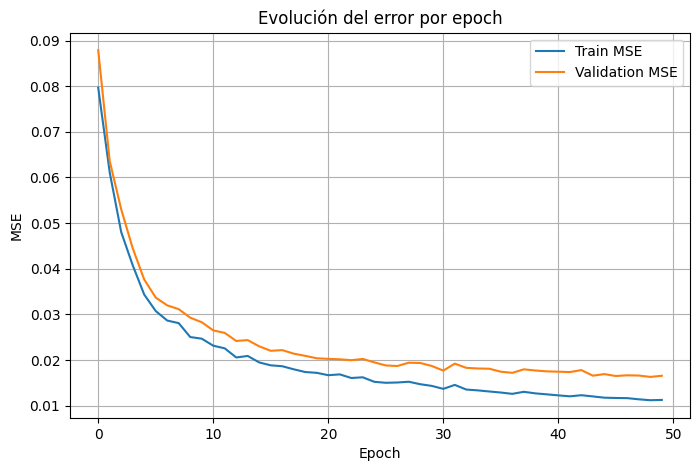

In [166]:
# 1. Predicciones en escala 0–1
predictions = net.predict(net.X_test)
preds_scaled = predictions.reshape(-1, 1)

print("--- PREDICTIONS EN ESCALA DE 0-1 ---")
print(preds_scaled)

# 2. Desescalar log_price
pred_log_price = y_scaler.inverse_transform(preds_scaled)

print("--- PREDICCIONES DES-ESCALADAS (log_price) ---")
print(pred_log_price)

# 3. Obtener precio real
final_prices = np.exp(pred_log_price)

print("--- PRECIOS FINALES ---")
print(final_prices)

train_errors, val_errors = net.loss_epochs()
plt.figure(figsize=(8,5))
plt.plot(train_errors, label="Train MSE")
if net.X_val.shape[0] > 0:
    plt.plot([e for e in val_errors if e is not None], label="Validation MSE")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("Evolución del error por epoch")
plt.legend()
plt.grid(True)
plt.show()

In [167]:
def mean_squared_error(y_true, y_pred):
    """Calcula el Error Cuadrático Medio (MSE)."""
    return np.mean((y_true - y_pred)**2)

def mean_absolute_error(y_true, y_pred):
    """Calcula el Error Absoluto Medio (MAE)."""
    return np.mean(np.abs(y_true - y_pred))

def mean_absolute_percentage_error(y_true, y_pred):
    """Calcula el Error Absoluto Porcentual Medio (MAPE)."""
    # Se usa np.clip para evitar la división por cero si y_true es 0
    y_true_clipped = np.clip(y_true, a_min=1e-8, a_max=None)
    return 100 * np.mean(np.abs((y_true - y_pred) / y_true_clipped))


--- MÉTRICAS DE EVALUACIÓN FINAL (PRECIO ORIGINAL) ---
MSE (Mean Squared Error): 33901781.80
MAE (Mean Absolute Error): 1509.48
MAPE (Mean Absolute Percentage Error): 13.88%
R2 (Coefficient of Determination): 0.7029


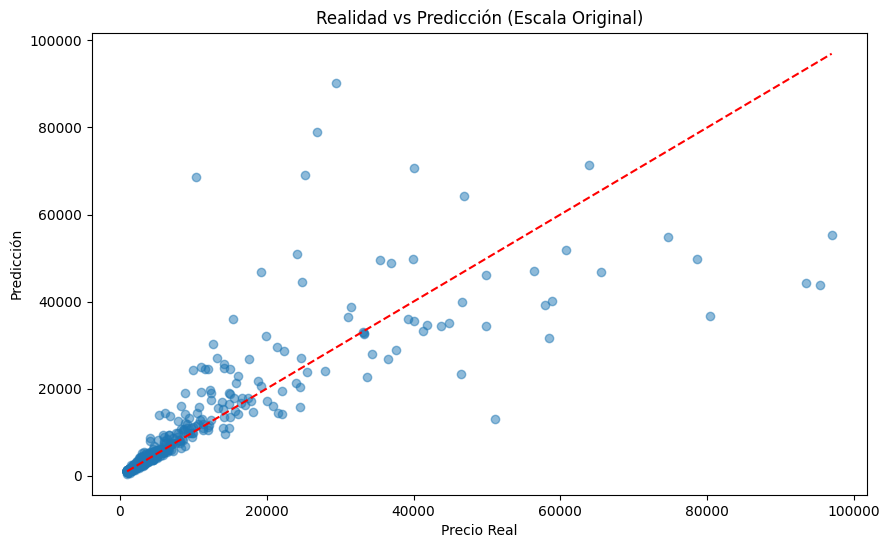

In [168]:
y_test_log = net.y_test.reshape(-1, 1)
y_test_log = y_scaler.inverse_transform(y_test_log) 

y_test_original = np.exp(y_test_log)

#print(y_test_original)
#print(final_prices)


print("\n--- MÉTRICAS DE EVALUACIÓN FINAL (PRECIO ORIGINAL) ---")

mse = mean_squared_error(y_test_original, final_prices)
print(f"MSE (Mean Squared Error): {mse:.2f}")

mae = mean_absolute_error(y_test_original, final_prices)
print(f"MAE (Mean Absolute Error): {mae:.2f}")

mape = mean_absolute_percentage_error(y_test_original, final_prices)
print(f"MAPE (Mean Absolute Percentage Error): {mape:.2f}%")

r2 = r2_score(y_test_original, final_prices)
print(f"R2 (Coefficient of Determination): {r2:.4f}")

plt.figure(figsize=(10,6))
plt.scatter(y_test_original, final_prices, alpha=0.5)
plt.plot([y_test_original.min(), y_test_original.max()], 
         [y_test_original.min(), y_test_original.max()], 'r--') # Línea perfecta
plt.xlabel('Precio Real')
plt.ylabel('Predicción')
plt.title('Realidad vs Predicción (Escala Original)')
plt.show()